In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
from datetime import datetime
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import cvxopt
import random
    
aeq_dir = "/mnt/c/Users/jan.zill/code/aequilibrae"
sys.path.append(aeq_dir)
from aequilibrae.paths.path_based.cythoncodetest import OpenBenchmark
# import node
# import link
# #import quadraticassignmentcyt
from aequilibrae.paths.path_based import TrafficAssignmentCy
aequ_dir = "/mnt/c/Users/jan.zill/code/aequilibrae"
sys.path.append(aequ_dir)

from aequilibrae.paths import TrafficAssignment  # noqa: E402
from aequilibrae.paths import Graph  # noqa: E402
from aequilibrae.paths.traffic_class import TrafficClass  # noqa: E402
from aequilibrae.matrix import AequilibraeMatrix, AequilibraeData  # noqa: E402
import matplotlib.pyplot as plt  # noqa: E402

from aequilibrae import logger  # noqa: E402
import logging  # noqa: E402

stdout_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_handler)


import utils

In [4]:
code_dir = "/mnt/c/Users/jan.zill/code"
tntp_dir = os.path.join(code_dir, "TransportationNetworks_aequilibrae")
scenario = "Anaheim"
folder = os.path.join(tntp_dir, scenario)
link_file =  "Anaheim_net.tntp"
trip_file =  "Anaheim_trips.tntp"

block_centroids = False

In [5]:
net = pd.read_csv(os.path.join(tntp_dir, scenario, link_file), skiprows=7, sep="\t")
net = net.reset_index().rename(columns={"index": "link_id"})

if scenario == "Anaheim":
    cols_ = ["link_id", "Tail", "Head", "Free Flow Time (min)", "Capacity (veh/h)", "B", "Power"]
    col_names = ["link_id", "a_node", "b_node", "time", "capacity", "alpha", "beta"]
elif scenario == "Berlin-Center":
    cols_ = ["link_id", "Init node ", "Term node ", "Free Flow Time ", "Capacity ", "B ", "Power "]
    col_names = ["link_id", "a_node", "b_node", "time", "capacity", "alpha", "beta"]
else:
    raise ValueError(f"Scenario {scenario} needs network column name check")

network = net[cols_]
network.columns = col_names
network = network.assign(direction=1)

g = Graph()
g.cost = network["time"].values
g.capacity = network["capacity"].values
g.free_flow_time = network["time"].values

g.network = network.to_records(index=False)
g.network_ok = True
g.status = "OK"

# # Loads and prepares the matrix. NOTE: This assumes conversion to aem has been done, Pedro should have a gist online. I also would have that code somewhere.
mat = AequilibraeMatrix()
mat.load(os.path.join(tntp_dir, scenario, "demand.aem"))
mat.computational_view(["matrix"])
zones = mat.zones
index = np.arange(zones) + 1

g.prepare_graph(index)
g.set_graph("time")
g.cost = np.array(g.cost, copy=True)
g.set_skimming(["time"])
# this might lead to large diffs:
g.set_blocked_centroid_flows(block_centroids)

# # Creates the assignment class
assigclass = TrafficClass(g, mat)

# Instantiates the traffic assignment problem
assig = TrafficAssignment()
assig.set_classes(assigclass)

# configures it properly
assig.set_vdf("BPR")
#if scenario == "Anaheim":
#    assig.set_vdf_parameters({"alpha": 0.15, "beta": 4.0})
#elif scenario == "Berlin-Center":
assig.set_vdf_parameters({"alpha": "alpha", "beta": "beta"})
#else:
#    raise ValueError(f"Scenario {scenario} needs BPR params")

assig.set_capacity_field("capacity")
assig.set_time_field("time")

#assig.set_algorithm("bfw")
assig.set_algorithm("bush-based")

assig.execute()
solution = pd.DataFrame(assigclass.graph.network)
solution["flow"] = assigclass.results.link_loads

In [6]:
%%time
bfw_res_ = utils.get_assignment_solution(tntp_dir, scenario, link_file, method="bfw", block_centroids=False, rgap=5*1e-5)

bfw Assignment STATS
Iteration, RelativeGap, stepsize
1,inf,1.0
2,0.11240350132103465,0.42753847828745567
3,0.008512480519396452,0.4466667887856495
4,0.0061369585759457205,0.2583684550132421
5,0.00190701393100553,0.9928446411966177
6,0.006766060707087605,0.17987928546335705
7,0.0019479525587521058,0.21815809910669395
8,0.0012489774143103253,0.2835471512770691
9,0.0011525073118256446,0.8830321859438492
10,0.0014305979833891306,0.22818967273849106
11,0.0006671239683778209,0.08894448614868473
12,0.00045741723614860246,0.07194176984638155
13,0.0002912472346597801,0.42848937877004234
14,0.0005181111919293948,0.9197722122187894
15,0.000448345154040941,0.039054811152209656
16,0.00024048297488393604,0.030145393807999823
17,0.0001663929820020378,0.26335164203205186
18,0.00014314827852800695,0.13310661399274584
19,0.00012063297547438309,0.14521535353036544
20,7.494373328119979e-05,0.16436255703858085
21,0.00013863073458596497,0.3126826673404474
22,0.00015944262240589848,0.9682323873773345
23,0.0

In [8]:
%%time
path_res_ = utils.get_assignment_solution(tntp_dir, scenario, link_file, method="bush-based", block_centroids=False, rgap=5*1e-5)

bush-based Assignment STATS
 Initialised data structures, num nodes = 416, num links = 914
 0th iteration done, cost = 1264524.25
Iteration 1, computed gap: inf, computed objective: 1208761.5
1,inf,1.0
Iteration 2, computed gap: inf, computed objective: 1206046.25
2,0.000910229489369474,1.0
Iteration 3, computed gap: 0.000910229489369474, computed objective: 1205672.5
3,0.0002401923865921196,1.0
Iteration 4, computed gap: 0.0002401923865921196, computed objective: 1205599.0
4,5.239975839810285e-05,1.0
bush-based Assignment finished. 4 iterations and 5.239975839810285e-05 final gap
CPU times: user 6.58 s, sys: 5.44 s, total: 12 s
Wall time: 1.85 s


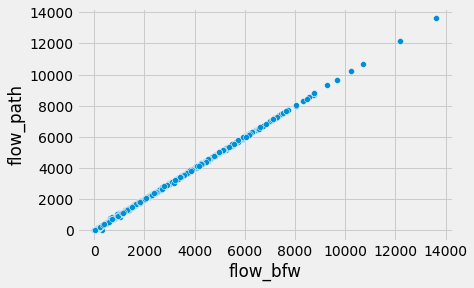

max diff in flow = 267.916
max rel diff in flow = 55.066%


,link_id_bfw,a_node,b_node,capacity_bfw,direction_bfw,flow_bfw,link_id_path,capacity_path,alpha,beta,direction_path,flow_path,abs_change,rel_change
704,704,354,355,5400,1,304.546982,704,5400,0.15,4,1,36.630737,267.916245,0.879721
667,667,342,343,5400,1,650.530030,667,5400,0.15,4,1,826.721558,176.191528,0.270843
706,706,355,343,5400,1,1017.598121,706,5400,0.15,4,1,871.433228,146.164893,0.143637
758,758,370,371,5400,1,925.147365,758,5400,0.15,4,1,1046.902588,121.755223,0.131606
760,760,371,355,5400,1,713.051139,760,5400,0.15,4,1,834.802429,121.751291,0.170747
702,702,354,342,5400,1,988.982204,702,5400,0.15,4,1,1090.046143,101.063938,0.102190
756,756,370,354,5400,1,1121.615256,756,5400,0.15,4,1,1023.715881,97.899375,0.087284
845,845,394,393,5400,1,3163.161190,845,5400,0.15,4,1,3070.334229,92.826961,0.029346
841,841,393,392,5400,1,1409.428345,841,5400,0.15,4,1,1326.485840,82.942505,0.058848
838,838,392,391,5400,1,1409.428345,838,5400,0.15,4,1,1326.485840,82.942505,0.058848


In [9]:
full_result = bfw_res_.drop(columns=['time']).merge(path_res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer', suffixes=['_bfw', '_path'])
sns.scatterplot(data=full_result, x='flow_bfw', y='flow_path');
plt.show();
full_result['abs_change'] = np.abs(full_result.flow_bfw - full_result.flow_path)
full_result['rel_change'] = full_result['abs_change'] / full_result['flow_bfw']
print(f"max diff in flow = {full_result['abs_change'].max():.3f}")
print(f"max rel diff in flow = {full_result['rel_change'].abs().max():.3f}%")
display(full_result.sort_values(by=['abs_change'], ascending=False).head(10))